# Assignment 7: Attention-based Neural Machine Translation - Kai Ponel & Hannan Mahadik



# Imports

In [137]:
!pip install "tensorflow-text>=2.10"
!pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [138]:
import numpy as np

import typing
from typing import Any, Tuple

import einops
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import tensorflow as tf
import tensorflow_text as tf_text

import pathlib

In [139]:
import os
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

project_dir = '/content/drive/MyDrive/IDL_Hannan_Kai/Task 7'
# project_dir = '/content/drive/MyDrive/ColabNotebooks/IDL_Hannan_Kai/Task 7'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Shape checker

In [140]:
#@title
class ShapeChecker():
  def __init__(self):
    # Keep a cache of every axis-name seen
    self.shapes = {}

  def __call__(self, tensor, names, broadcast=False):
    if not tf.executing_eagerly():
      return

    parsed = einops.parse_shape(tensor, names)

    for name, new_dim in parsed.items():
      old_dim = self.shapes.get(name, None)
      
      if (broadcast and new_dim == 1):
        continue

      if old_dim is None:
        # If the axis name is new, add its length to the cache.
        self.shapes[name] = new_dim
        continue

      if new_dim != old_dim:
        raise ValueError(f"Shape mismatch for dimension: '{name}'\n"
                         f"    found: {new_dim}\n"
                         f"    expected: {old_dim}\n")

# Data Stuff

## Importing dataset

In [141]:
path_to_file = pathlib.Path(os.path.join(project_dir, "deu.txt"))

In [142]:
def load_data(path):
  text = path.read_text(encoding='utf-8')

  lines = text.splitlines()
  pairs = [line.split('\t')[:-1] for line in lines]

  context = np.array([context for target, context in pairs])
  target = np.array([target for target, context in pairs])

  return target, context

In [143]:
target_raw, context_raw = load_data(path_to_file)
print(context_raw[-1])

Ohne Zweifel findet sich auf dieser Welt zu jedem Mann genau die richtige Ehefrau und umgekehrt; wenn man jedoch in Betracht zieht, dass ein Mensch nur Gelegenheit hat, mit ein paar hundert anderen bekannt zu sein, von denen ihm nur ein Dutzend oder weniger nahesteht, darunter höchstens ein oder zwei Freunde, dann erahnt man eingedenk der Millionen Einwohner dieser Welt leicht, dass seit Erschaffung ebenderselben wohl noch nie der richtige Mann der richtigen Frau begegnet ist.


In [144]:
print(target_raw[-1])

Doubtless there exists in this world precisely the right woman for any given man to marry and vice versa; but when you consider that a human being has the opportunity of being acquainted with only a few hundred people, and out of the few hundred that there are but a dozen or less whom he knows intimately, and out of the dozen, one or two friends at most, it will easily be seen, when we remember the number of millions who inhabit this world, that probably, since the earth was created, the right man has never yet met the right woman.


## Creating Tf.Data Dataset


In [145]:
BUFFER_SIZE = len(context_raw)
BATCH_SIZE = 64

is_train = np.random.uniform(size=(len(target_raw),)) < 0.8

train_raw = (
    tf.data.Dataset
    .from_tensor_slices((context_raw[is_train], target_raw[is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))
val_raw = (
    tf.data.Dataset
    .from_tensor_slices((context_raw[~is_train], target_raw[~is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))

In [146]:
for example_context_strings, example_target_strings in train_raw.take(1):
  print(example_context_strings[:5])
  print()
  print(example_target_strings[:5])
  break

tf.Tensor(
[b'Darum geht es hier nicht.' b'Wir wissen jetzt, dass das nicht stimmt.'
 b'Der Himmel ist fast jeden Tag klar.'
 b'Tom und Maria spielten Brettspiele.'
 b'Seine Technik war einzigartig und absolut unglaublich.'], shape=(5,), dtype=string)

tf.Tensor(
[b"This isn't about that." b"We now know that's not true."
 b'The sky is clear almost every day.' b'Tom and Mary played board games.'
 b'His technique was unique and absolutely amazing.'], shape=(5,), dtype=string)


## Text Preprocessing

### Standardization

In [147]:
example_text = tf.constant('Tom klang glücklich.')

print(example_text.numpy())
print(tf_text.normalize_utf8(example_text, 'NFKD').numpy())

b'Tom klang gl\xc3\xbccklich.'
b'Tom klang glu\xcc\x88cklich.'


In [148]:
def tf_lower_and_split_punct(text):
  # Split accented characters.
  text = tf_text.normalize_utf8(text, 'NFKD')
  text = tf.strings.lower(text)
  # Keep space, a to z, and select punctuation.
  text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
  # Add spaces around punctuation.
  text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
  # Strip whitespace.
  text = tf.strings.strip(text)

  text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
  return text

In [149]:
print(example_text.numpy().decode())
print(tf_lower_and_split_punct(example_text).numpy().decode())

Tom klang glücklich.
[START] tom klang glucklich . [END]


### Vectorization

In [150]:
max_vocab_size = 5000

context_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)

context_text_processor.adapt(train_raw.map(lambda context, target: context))

print(context_text_processor.get_vocabulary()[:10])

target_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)

target_text_processor.adapt(train_raw.map(lambda context, target: target))
print(target_text_processor.get_vocabulary()[:10])

['', '[UNK]', '[START]', '[END]', '.', ',', 'ich', 'tom', '?', 'nicht']
['', '[UNK]', '[START]', '[END]', '.', 'tom', 'to', 'you', 'the', 'i']


In [151]:
example_tokens = context_text_processor(example_context_strings)
example_tokens[:3, :]

<tf.RaggedTensor [[2, 600, 139, 15, 56, 9, 4, 3], [2, 23, 148, 92, 5, 22, 11, 9, 502, 4, 3],
 [2, 18, 936, 10, 218, 224, 161, 814, 4, 3]]>

In [152]:
context_vocab = np.array(context_text_processor.get_vocabulary())
tokens = context_vocab[example_tokens[0].numpy()]
' '.join(tokens)

'[START] darum geht es hier nicht . [END]'

## Process dataset

In [153]:
def process_text(context, target):
  context = context_text_processor(context).to_tensor()
  target = target_text_processor(target)
  targ_in = target[:,:-1].to_tensor()
  targ_out = target[:,1:].to_tensor()
  return (context, targ_in), targ_out


train_ds = train_raw.map(process_text, tf.data.AUTOTUNE)
val_ds = val_raw.map(process_text, tf.data.AUTOTUNE)

In [154]:
for (ex_context_tok, ex_tar_in), ex_tar_out in train_ds.take(1):
  print(ex_context_tok[0, :10].numpy()) 
  print()
  print(ex_tar_in[0, :10].numpy()) 
  print(ex_tar_out[0, :10].numpy()) 

[  2  23 851  11   9  71   4   3   0   0]

[  2  49  41 820   6  15  13   4   0   0]
[ 49  41 820   6  15  13   4   3   0   0]


# Encoder

In [155]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, text_processor, units):
    super(Encoder, self).__init__()
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.units = units
    
    # The embedding layer converts tokens to vectors
    self.embedding = tf.keras.layers.Embedding(self.vocab_size, units,
                                               mask_zero=True)

    # The RNN layer processes those vectors sequentially.
    self.rnn = tf.keras.layers.Bidirectional(
        merge_mode='sum',
        layer=tf.keras.layers.GRU(units,
                            # Return the sequence and state
                            return_sequences=True,
                            recurrent_initializer='glorot_uniform'))

  def call(self, x):
    # shape_checker = ShapeChecker()
    # shape_checker(x, 'batch s')

    # 2. The embedding layer looks up the embedding vector for each token.
    x = self.embedding(x)
    # shape_checker(x, 'batch s units')

    # 3. The GRU processes the sequence of embeddings.
    x = self.rnn(x)
    # shape_checker(x, 'batch s units')

    # 4. Returns the new sequence of embeddings.
    return x

  def convert_input(self, texts):
    texts = tf.convert_to_tensor(texts)
    if len(texts.shape) == 0:
      texts = tf.convert_to_tensor(texts)[tf.newaxis]
    context = self.text_processor(texts).to_tensor()
    context = self(context)
    return context

# Attention Layers

In [156]:
class CrossAttention(tf.keras.layers.Layer):
  def __init__(self, units, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(key_dim=units, num_heads=1, **kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

  def call(self, input, return_attention_scores=True):
    x = input[0]
    context = input[1]

    shape_checker = ShapeChecker()
 
    shape_checker(x, 'batch t units')
    shape_checker(context, 'batch s units')

    attn_output, attn_scores = self.mha(
        query=x,
        value=context,
        return_attention_scores=True)
    
    shape_checker(x, 'batch t units')
    shape_checker(attn_scores, 'batch heads t s')
    
    # Cache the attention scores for plotting later.
    attn_scores = tf.reduce_mean(attn_scores, axis=1)
    # shape_checker(attn_scores, 'batch t s')
    self.last_attention_weights = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)
    if not return_attention_scores:
      return x
    return (x, self.last_attention_weights) # return (x, last_attention_weights)

# Decoder

In [157]:
class Decoder(tf.keras.layers.Layer):
  # @ #classmethod
  # def add_method(cls, fun):
  #   setattr(cls, fun.__name__, fun)
  #   return fun

  def __init__(self, text_processor, units, attention):
    super(Decoder, self).__init__()
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.word_to_id = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]')
    self.id_to_word = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]',
        invert=True)
    self.start_token = self.word_to_id('[START]')
    self.end_token = self.word_to_id('[END]')

    self.last_attention_weights = None

    self.units = units


    # 1. The embedding layer converts token IDs to vectors
    self.embedding = tf.keras.layers.Embedding(self.vocab_size,
                                               units, mask_zero=True)

    # 2. The RNN keeps track of what's been generated so far.
    self.rnn = tf.keras.layers.GRU(units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

    # 3. The RNN output will be the query for the attention layer.
    self.attention = attention(units)

    # 4. This fully connected layer produces the logits for each
    # output token.
    self.output_layer = tf.keras.layers.Dense(self.vocab_size)


#------------------------------------------------------------------------------
  # @Decoder.add_method
  def get_initial_state(self, context):
    batch_size = tf.shape(context)[0]
    start_tokens = tf.fill([batch_size, 1], self.start_token)
    done = tf.zeros([batch_size, 1], dtype=tf.bool)
    embedded = self.embedding(start_tokens)

    return start_tokens, done, self.rnn.get_initial_state(embedded)[0]


#------------------------------------------------------------------------------
  # @Decoder.add_method
  def tokens_to_text(self, tokens):
    words = self.id_to_word(tokens)
    result = tf.strings.reduce_join(words, axis=-1, separator=' ')
    result = tf.strings.regex_replace(result, '^ *\[START\] *', '')
    result = tf.strings.regex_replace(result, ' *\[END\] *$', '')

    return result

#------------------------------------------------------------------------------
# @Decoder.add_method
  def get_next_token(self, context, next_token, done, state, temperature = 0.0):
    logits, state = self(
      context, next_token,
      state = state,
      return_state=True) 
    
    # if temperature == 0.0:
    next_token = tf.argmax(logits, axis=-1)
    # else:
      # logits = logits[:, -1, :]/temperature
      # next_token = tf.random.categorical(logits, num_samples=1)

    # If a sequence produces an `end_token`, set it `done`
    done = done | (next_token == self.end_token)
    # Once a sequence is done it only produces 0-padding.
    next_token = tf.where(done, tf.constant(0, dtype=tf.int64), next_token)
    
    return next_token, done, state

#------------------------------------------------------------------------------ 
  def call(self, context, x, state=None, return_state=False):  
    # shape_checker = ShapeChecker()
    # shape_checker(x, 'batch t')
    # shape_checker(context, 'batch s units')

    # 1. Lookup the embeddings
    x = self.embedding(x)
    # shape_checker(x, 'batch t units')

    # 2. Process the target sequence.
    x, state = self.rnn(x, initial_state=state)
    # shape_checker(x, 'batch t units')

    # 3. Use the RNN output as the query for the attention over the context.
    (x, self.last_attention_weights) = self.attention([x, context], return_attention_scores=True) 
    # print(x)
    # print(self.last_attention_weights)
    # shape_checker(x, 'batch t units')
    # shape_checker(self.last_attention_weights, 'batch t s')

    # Step 4. Generate logit predictions for the next token.
    logits = self.output_layer(x)
    # shape_checker(logits, 'batch t target_vocab_size')

    if return_state:
      return logits, state
    else:
      return logits

# Model

In [158]:
class Translator(tf.keras.Model):
  # @ #classmethod
  # def add_method(cls, fun):
  #   setattr(cls, fun.__name__, fun)
  #   return fun

  def __init__(self, units,
               context_text_processor,
               target_text_processor,
               attention_mechanism):
    super().__init__()
    # Build the encoder and decoder
    encoder = Encoder(context_text_processor, units)
    # encoder = Encoder(context_text_processor2, units)
    decoder = Decoder(target_text_processor, units, attention=attention_mechanism)
    # decoder = Decoder(target_text_processor2, units, attention=attention_mechanism)

    self.encoder = encoder
    self.decoder = decoder

#-----------------------------------------------------------------------------

  def translate(self,texts, *, max_length=50, temperature=0.0):
    # Process the input texts
    context = self.encoder.convert_input(texts)
    batch_size = tf.shape(texts)[0]

    # Setup the loop inputs
    tokens = []
    attention_weights = []
    next_token, done, state = self.decoder.get_initial_state(context)

    for _ in range(max_length):
      # Generate the next token
      next_token, done, state = self.decoder.get_next_token(
          context, next_token, done,  state, temperature)
          
      # Collect the generated tokens
      tokens.append(next_token)
      attention_weights.append(self.decoder.last_attention_weights)
      
      if tf.executing_eagerly() and tf.reduce_all(done):
        break

    # Stack the lists of tokens and attention weights.
    tokens = tf.concat(tokens, axis=-1)   # t*[(batch 1)] -> (batch, t)
    self.last_attention_weights = tf.concat(attention_weights, axis=1)  # t*[(batch 1 s)] -> (batch, t s)

    result = self.decoder.tokens_to_text(tokens)
    return result

#-----------------------------------------------------------------------------

  def plot_attention(self, text, **kwargs):
    assert isinstance(text, str)
    output = self.translate([text], **kwargs)
    output = output[0].numpy().decode()

    attention = self.last_attention_weights[0]

    context = tf_lower_and_split_punct(text)
    context = context.numpy().decode().split()

    # output = tf_lower_and_split_punct(output)
    output = tf_lower_and_split_punct(output)
    output = output.numpy().decode().split()[1:]

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)

    ax.matshow(attention, cmap='viridis', vmin=0.0)

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + output, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    ax.set_xlabel('Input text')
    ax.set_ylabel('Output text')

#-----------------------------------------------------------------------------

  def call(self, inputs):
    context, x = inputs
    context = self.encoder(context)
    logits = self.decoder(context, x)

    #TODO(b/250038731): remove this
    try:
      # Delete the keras mask, so keras doesn't scale the loss+accuracy. 
      del logits._keras_mask
    except AttributeError:
      pass

    return logits

# Loss and Accuracy

In [159]:
def masked_loss(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')
    loss = loss_fn(y_true, y_pred)

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, loss.dtype)
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss)/tf.reduce_sum(mask)

In [160]:
def masked_acc(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, y_true.dtype)
    
    match = tf.cast(y_true == y_pred, tf.float32)
    mask = tf.cast(y_true != 0, tf.float32)
    
    return tf.reduce_sum(match)/tf.reduce_sum(mask)

# Training

## Step-by-step (Encoding -> AttentionLayer -> Decode)

### Encode:

In [161]:
UNITS = 1024
# Encode the input sequence.
encoder = Encoder(context_text_processor, UNITS)
ex_context = encoder(ex_context_tok)

print(f'Context tokens, shape (batch, s): {ex_context_tok.shape}')
print(f'Encoder output, shape (batch, s, units): {ex_context.shape}')

Context tokens, shape (batch, s): (64, 20)
Encoder output, shape (batch, s, units): (64, 20, 1024)


### Attention Layer:

In [162]:
initializer = tf.keras.initializers.HeNormal()
regularizer = tf.keras.regularizers.L2(1e-4)

In [163]:
# attention_layer = tf.keras.layers.AdditiveAttention(UNITS)

attention_layer = CrossAttention(UNITS)

# Attend to the encoded tokens
embed = tf.keras.layers.Embedding(target_text_processor.vocabulary_size(),
                                  output_dim=UNITS, mask_zero=True, embeddings_regularizer = regularizer, embeddings_initializer=initializer)
ex_tar_embed = embed(ex_tar_in)

(x, last_attention_weights) = attention_layer([ex_tar_embed, ex_context], return_attention_scores=True)

print(f'Context sequence, shape (batch, s, units): {ex_context.shape}')
print(f'Target sequence, shape (batch, t, units): {ex_tar_embed.shape}')
print(f'Attention result, shape (batch, t, units): {x.shape}')
print(f'Attention weights, shape (batch, t, s):    {last_attention_weights.shape}')

Context sequence, shape (batch, s, units): (64, 20, 1024)
Target sequence, shape (batch, t, units): (64, 18, 1024)
Attention result, shape (batch, t, units): (64, 18, 1024)
Attention weights, shape (batch, t, s):    (64, 18, 20)


### Decode:

In [164]:
# decoder = Decoder(target_text_processor, UNITS, attention=tf.keras.layers.AdditiveAttention)
decoder = Decoder(target_text_processor, UNITS, attention=CrossAttention)

logits = decoder(ex_context, ex_tar_in)

print(f'encoder output shape: (batch, s, units) {ex_context.shape}')
print(f'input target tokens shape: (batch, t) {ex_tar_in.shape}')
print(f'logits shape shape: (batch, target_vocabulary_size) {logits.shape}')

encoder output shape: (batch, s, units) (64, 20, 1024)
input target tokens shape: (batch, t) (64, 18)
logits shape shape: (batch, target_vocabulary_size) (64, 18, 5000)


## Different Model specifications:

### Using CrossAttention (as per Tutorial)

In [165]:
model = Translator(UNITS, context_text_processor, target_text_processor, attention_mechanism=CrossAttention)

logits = model((ex_context_tok, ex_tar_in))

print(f'Context tokens, shape: (batch, s, units) {ex_context_tok.shape}')
print(f'Target tokens, shape: (batch, t) {ex_tar_in.shape}')
print(f'logits, shape: (batch, t, target_vocabulary_size) {logits.shape}')

Context tokens, shape: (batch, s, units) (64, 20)
Target tokens, shape: (batch, t) (64, 18)
logits, shape: (batch, t, target_vocabulary_size) (64, 18, 5000)


In [166]:
model.compile(optimizer='adam',
              loss=masked_loss,
              metrics=[masked_acc, masked_loss])

#### Model Training

In [167]:
history = model.fit(
    train_ds.repeat(), 
    epochs=20,
    steps_per_epoch = 100,
    validation_data=val_ds,
    validation_steps = 20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3)])

Epoch 1/20
100/100 [==============================] - 47s 272ms/step - loss: 4.0340 - masked_acc: 0.3873 - masked_loss: 4.0340 - val_loss: 3.2307 - val_masked_acc: 0.4588 - val_masked_loss: 3.2307
Epoch 2/20
100/100 [==============================] - 10s 101ms/step - loss: 2.9516 - masked_acc: 0.5069 - masked_loss: 2.9516 - val_loss: 2.7201 - val_masked_acc: 0.5412 - val_masked_loss: 2.7201
Epoch 3/20
100/100 [==============================] - 9s 90ms/step - loss: 2.5312 - masked_acc: 0.5605 - masked_loss: 2.5312 - val_loss: 2.4005 - val_masked_acc: 0.5720 - val_masked_loss: 2.4005
Epoch 4/20
100/100 [==============================] - 9s 85ms/step - loss: 2.2846 - masked_acc: 0.5939 - masked_loss: 2.2846 - val_loss: 2.2084 - val_masked_acc: 0.6057 - val_masked_loss: 2.2084
Epoch 5/20
100/100 [==============================] - 8s 83ms/step - loss: 2.1025 - masked_acc: 0.6196 - masked_loss: 2.1025 - val_loss: 2.0623 - val_masked_acc: 0.6209 - val_masked_loss: 2.0623
Epoch 6/20
100/100 [=

#### Graphs:

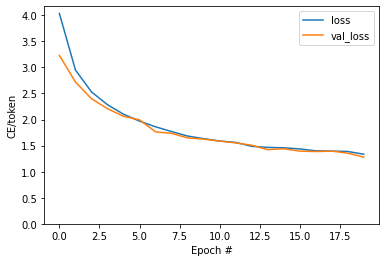

In [168]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

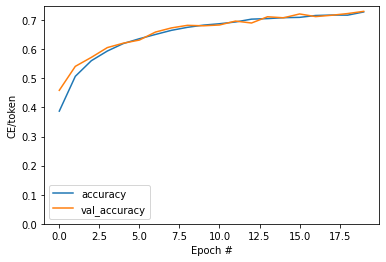

In [169]:
plt.plot(history.history['masked_acc'], label='accuracy')
plt.plot(history.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

#### Translate

In [170]:
result = model.translate(['Ich gehe heute nach Hause.'])
result[0].numpy().decode()

'im going to be home today . '

#### Attention Plot

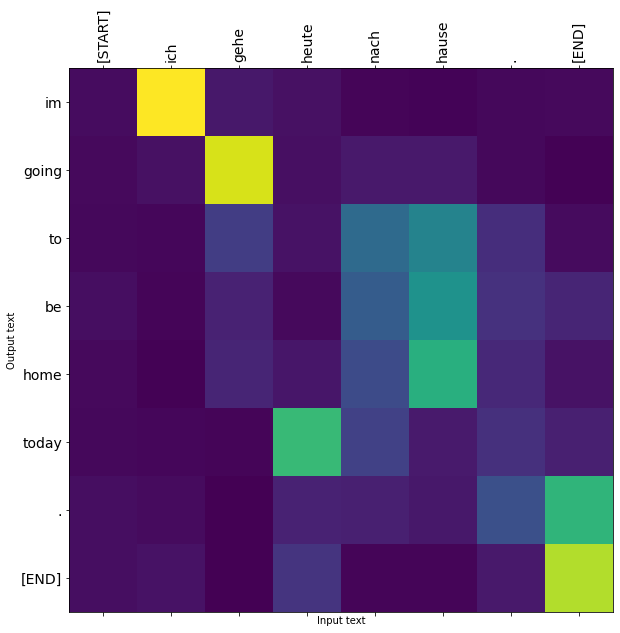

In [171]:
model.plot_attention('Ich gehe heute nach Hause.')

### Using tf.keras.layers.Attention

In [172]:
model = Translator(UNITS, context_text_processor, target_text_processor, attention_mechanism=tf.keras.layers.Attention)

logits = model((ex_context_tok, ex_tar_in))

print(f'Context tokens, shape: (batch, s, units) {ex_context_tok.shape}')
print(f'Target tokens, shape: (batch, t) {ex_tar_in.shape}')
print(f'logits, shape: (batch, t, target_vocabulary_size) {logits.shape}')

Context tokens, shape: (batch, s, units) (64, 20)
Target tokens, shape: (batch, t) (64, 18)
logits, shape: (batch, t, target_vocabulary_size) (64, 18, 5000)


In [173]:
model.compile(optimizer='adam',
              loss=masked_loss,
              metrics=[masked_acc, masked_loss])

#### Model Training

In [174]:
history = model.fit(
    train_ds.repeat(), 
    epochs=20,
    steps_per_epoch = 100,
    validation_data=val_ds,
    validation_steps = 20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3)])

Epoch 1/20
120/120 [==============================] - 33s 157ms/step - loss: 5.0431 - masked_acc: 0.2518 - masked_loss: 5.0431 - val_loss: 4.3075 - val_masked_acc: 0.3221 - val_masked_loss: 4.3075
Epoch 2/20
120/120 [==============================] - 12s 97ms/step - loss: 4.0318 - masked_acc: 0.3606 - masked_loss: 4.0318 - val_loss: 3.7707 - val_masked_acc: 0.3954 - val_masked_loss: 3.7707
Epoch 3/20
120/120 [==============================] - 11s 90ms/step - loss: 3.5588 - masked_acc: 0.4235 - masked_loss: 3.5588 - val_loss: 3.3946 - val_masked_acc: 0.4397 - val_masked_loss: 3.3946
Epoch 4/20
120/120 [==============================] - 9s 72ms/step - loss: 3.2213 - masked_acc: 0.4623 - masked_loss: 3.2213 - val_loss: 2.9801 - val_masked_acc: 0.4975 - val_masked_loss: 2.9801
Epoch 5/20
120/120 [==============================] - 9s 72ms/step - loss: 2.8694 - masked_acc: 0.5084 - masked_loss: 2.8694 - val_loss: 2.6967 - val_masked_acc: 0.5312 - val_masked_loss: 2.6967
Epoch 6/20
120/120 [=

#### Graphs:

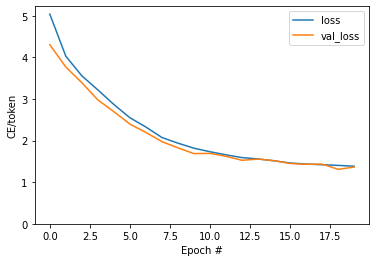

In [175]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

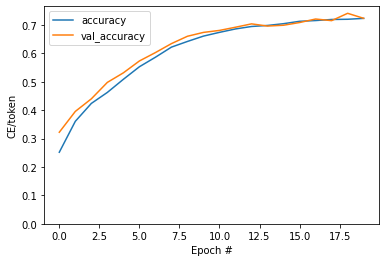

In [176]:
plt.plot(history.history['masked_acc'], label='accuracy')
plt.plot(history.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

#### Translate

In [177]:
result = model.translate(['Ich gehe heute nach Hause.'])
result[0].numpy().decode()

'im going home today . '

#### Attention Plot

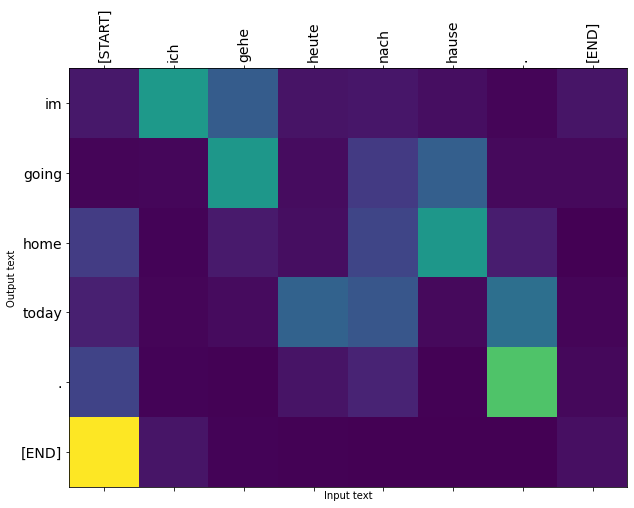

In [178]:
model.plot_attention('Ich gehe heute nach Hause.')

### Using tf.keras.layers.AdditiveAttention

In [179]:
model = Translator(UNITS, context_text_processor, target_text_processor, attention_mechanism=tf.keras.layers.AdditiveAttention)

logits = model((ex_context_tok, ex_tar_in))

print(f'Context tokens, shape: (batch, s, units) {ex_context_tok.shape}')
print(f'Target tokens, shape: (batch, t) {ex_tar_in.shape}')
print(f'logits, shape: (batch, t, target_vocabulary_size) {logits.shape}')

Context tokens, shape: (batch, s, units) (64, 20)
Target tokens, shape: (batch, t) (64, 18)
logits, shape: (batch, t, target_vocabulary_size) (64, 18, 5000)


In [180]:
model.compile(optimizer='adam',
              loss=masked_loss,
              metrics=[masked_acc, masked_loss])

#### Model Training

In [181]:
history = model.fit(
    train_ds.repeat(), 
    epochs=20,
    steps_per_epoch = 100,
    validation_data=val_ds,
    validation_steps = 20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3)])

Epoch 1/20
120/120 [==============================] - 33s 176ms/step - loss: 5.2227 - masked_acc: 0.2071 - masked_loss: 5.2227 - val_loss: 4.3257 - val_masked_acc: 0.3166 - val_masked_loss: 4.3257
Epoch 2/20
120/120 [==============================] - 12s 98ms/step - loss: 4.0838 - masked_acc: 0.3470 - masked_loss: 4.0838 - val_loss: 3.8200 - val_masked_acc: 0.3893 - val_masked_loss: 3.8200
Epoch 3/20
120/120 [==============================] - 11s 87ms/step - loss: 3.5960 - masked_acc: 0.4078 - masked_loss: 3.5960 - val_loss: 3.3118 - val_masked_acc: 0.4399 - val_masked_loss: 3.3118
Epoch 4/20
120/120 [==============================] - 10s 80ms/step - loss: 3.1968 - masked_acc: 0.4540 - masked_loss: 3.1968 - val_loss: 3.0362 - val_masked_acc: 0.4713 - val_masked_loss: 3.0362
Epoch 5/20
120/120 [==============================] - 9s 77ms/step - loss: 2.8930 - masked_acc: 0.4955 - masked_loss: 2.8930 - val_loss: 2.7854 - val_masked_acc: 0.5107 - val_masked_loss: 2.7854
Epoch 6/20
120/120 [

#### Graphs:

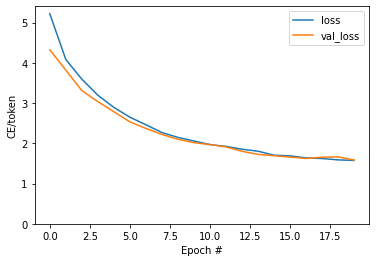

In [182]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

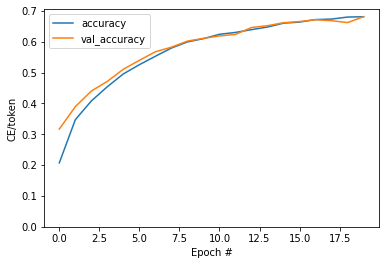

In [183]:
plt.plot(history.history['masked_acc'], label='accuracy')
plt.plot(history.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

#### Translate

In [184]:
result = model.translate(['Ich gehe heute nach Hause.'])
result[0].numpy().decode()

'im going home today . '

#### Attention Plot

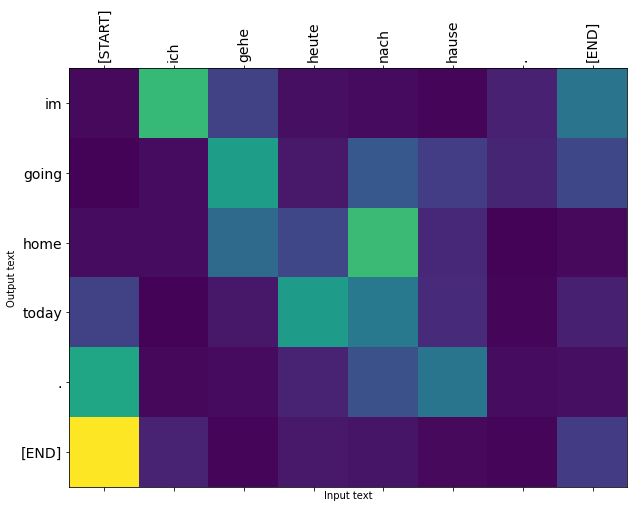

In [185]:
model.plot_attention('Ich gehe heute nach Hause.')

# Questions:
1. Q: Which parts of the sentence are used as a token? Each character, each word, or are some words split up?<br>
A: Words are used as tokens. The TextVectorization split's the words based on a seperator which is a whitespace by default. _The Combination of words like "didn't" would be one token according to this, am I correct? It is the oppositve of wordsplitting but maybe worth noting? However, maybe I'm wrong_

2. Q: Do the same tokens in different language have the same ID?
e.g. Would the same token index map to the German word die and to the English word die?<br>
A: No, they are processed separately. Different dictionaries - Same combinations of characters do not correspond to the same ID's in different languages dictionries.

3. Q: Is the decoder attending to all previous positions, including the previous decoder predictions?<br>
A: Yes, but not in training (?). During training the decoder uses Teacher Forcing so the decoder is taking the previous decoder predictions into account. When applied to unseen data there is no correct previous output to fallback to so the decoder uses its own previous output. _I'm actually not 100% sure, that we actually use teacher forcing in training, but it would make sense to me xD. If not the answer is simply "yes" I assume_

4. Q: Does the encoder output change in different decoding steps? <br>
A: No, the output of the encoder is independent of the decoding process.

5. Q: Does the context vector change in different decoding steps?<br>
A: Yes, different parts of the sentence are attended to at different points.

6. Q: The decoder uses teacher forcing. Does this mean the time steps can be computed in parallel? <br>
A: There are hidden-to-hidden connections, so no, cannot be parallelized

7. Q: Why is a mask applied to the loss function?<br>
A: To ensure all sequences are of the same length

8. Q: When translating the same sentence multiple times, do you get the same result? Why (not)? If not, what changes need to be made to get the same result each time?<br>
A: Yes, we got the same result for the translations each time. 


# ----------------------------------------------------------------------------------------

# Extra

# Hindi

### Importing Hindi Dataset 

In [186]:
path_to_file2 = pathlib.Path(os.path.join(project_dir, "hin.txt"))
target_raw2, context_raw2 = load_data(path_to_file2)

In [187]:
print(target_raw2[-1])
print(context_raw2[-1])

When I was a kid, touching bugs didn't bother me a bit. Now I can hardly stand looking at pictures of them.
जब मैं बच्चा था, मुझे कीड़ों को छूने से कोई परेशानी नहीं होती थी, पर अब मैं उनकी तस्वीरें देखना भी बर्दाश्त नहीं कर सकता।


### Lower and Split Punct Function

In [188]:
# import unicodedata

# # Converts the unicode file to ascii
# def unicode_to_ascii(s):
#   return ''.join(c for c in tf_text.normalize_utf8(s, 'NFD')
#       if unicodedata.category(c) != 'Mn')

def tf_lower_and_split_punct2(text):
  # # text = unicode_to_ascii(text)
  # text = re.sub(r"([?.!,¿])", r" \1 ", text)
  # text = re.sub(r'[" "]+', " ", text)

  # Split accented characters.
  text = tf_text.normalize_utf8(text, 'NFKD')
  text = tf.strings.lower(text)
  # Keep space, a to z, and select punctuation.
  text = tf.strings.regex_replace(text, '[^ a-zA-Z\u0900-\u097f?.!,¿]+', '')
  # text = tf.strings.regex_replace(text, pattern=r'.^ a-z.', rewrite=r'')
  text = tf.strings.regex_replace(text, '[,?!]', r' \0 ')
  # Strip whitespace.
  text = tf.strings.strip(text)

  text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
  return text

### Hindi Data

In [189]:
BUFFER_SIZE = len(context_raw2)
BATCH_SIZE = 32

is_train = np.random.uniform(size=(len(target_raw2),)) < 0.6

train_raw2 = (
    tf.data.Dataset
    .from_tensor_slices((context_raw2[is_train], target_raw2[is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))
val_raw2 = (
    tf.data.Dataset
    .from_tensor_slices((context_raw2[~is_train], target_raw2[~is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))

In [190]:
hindi = []

for example_context_strings2, example_target_strings2 in train_raw2.take(1):
  for x in example_context_strings2[:5]:
    print("".join([chr(i) for i in tf.strings.unicode_decode(x, 'utf-8')]))
  # print(example_context_strings2[:5])
  print()
  print(example_target_strings2[:5])
  # for x in example_context_strings2:
    # hindi.append("".join([chr(i) for i in tf.strings.unicode_decode(x, 'utf-8')]))
  # for x in example_context_strings2[:5]:
    # print("".join([chr(i) for i in tf.strings.unicode_decode(x, 'utf-8')]))
  # h_text = tf.strings.join(['[START]', hindi, '[END]'], separator=' ')
  break

बैठिए।
अगर आपके पास समय हो तो हमसे मिलने आईएगा।
टॉम अभी तक नहीं जानता कि यह कैसे करना है।
क्योटो में बहुत सारे पुराने मंदिर हैं।
मेरा भाई टोक्यो में रहता है।

tf.Tensor(
[b'Please sit down.' b'If you have time, please drop in on us.'
 b"Tom doesn't know how to do that yet."
 b'There are many old temples in Kyoto.' b'My brother lives in Tokyo.'], shape=(5,), dtype=string)


In [191]:
# print(hindi[1])
# print(h_text)

In [192]:
example_text2 = tf.constant('हम अच्छे दोस्त हैं।')

print(example_text2.numpy().decode())
print(tf_lower_and_split_punct2(example_text2).numpy().decode())

हम अच्छे दोस्त हैं।
[START] हम अच्छे दोस्त हैं। [END]


In [193]:
max_vocab_size = 10000

context_text_processor2 = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct2,
    max_tokens=max_vocab_size,
    ragged=True)

context_text_processor2.adapt(train_raw2.map(lambda context, target: context))

print(context_text_processor2.get_vocabulary()[:100])

target_text_processor2 = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)

target_text_processor2.adapt(train_raw2.map(lambda context, target: target))
print(target_text_processor2.get_vocabulary()[:10])

# eng2_context_text_processor =  tf.keras.layers.TextVectorization(
#     standardize=tf_lower_and_split_punct2,
#     max_tokens=max_vocab_size,
#     ragged=True)

# eng2_context_text_processor.adapt(trans_data)

# print(eng2_context_text_processor.get_vocabulary()[:10])

# # eng2_context_text_processor =  tf.keras.layers.TextVectorization(
# #     standardize=tf_lower_and_split_punct,
# #     max_tokens=max_vocab_size,
# #     ragged=True)

# # eng2_context_text_processor.adapt(train_raw_h.map(lambda context, target: context))
# # print(eng2_context_text_processor.get_vocabulary()[:10])

# # h_target_text_processor =  tf.keras.layers.TextVectorization(
# #     standardize=tf_lower_and_split_punct2,
# #     max_tokens=max_vocab_size,
# #     ragged=True)

# # h_target_text_processor.adapt(trans_data)

# # print(h_target_text_processor.get_vocabulary()[:10])


# h2_target_text_processor =  tf.keras.layers.TextVectorization(
#     standardize=tf_lower_and_split_punct,
#     max_tokens=max_vocab_size,
#     ragged=True)
# h2_target_text_processor.adapt(train_raw_h.map(lambda context, target: target))
# print(h2_target_text_processor.get_vocabulary()[:10])

['', '[UNK]', '[START]', '[END]', 'है।', '?', 'में', 'नहीं', 'वह', 'मैं', 'से', 'है', 'क्या', 'मुझे', 'के', 'को', 'की', 'हैं।', 'हो', 'बहुत', 'का', 'था।', 'उसने', 'यह', 'तुम', 'हूँ।', 'एक', 'पर', 'कि', 'कर', 'लिए', 'मेरे', ',', 'टॉम', 'हैं', 'तुम्हें', 'ने', 'उसे', 'मैंने', 'भी', 'इस', 'अपने', 'रहा', 'मेरी', 'और', 'ही', 'करने', 'हम', 'तो', 'अपनी', 'कोई', 'कल', 'पास', 'पता', 'गया।', 'था', 'काम', 'बात', 'घर', 'उसकी', 'उस', 'समय', 'उसके', 'गया', 'आप', 'करना', 'सकते', 'थी।', 'किया।', 'साथ', 'लगता', 'रही', 'अच्छा', 'मेरा', 'बजे', 'तुम्हारे', 'तक', 'भारत', 'करते', 'सकता', 'रहे', '!', '।', 'यहाँ', 'मुझसे', 'पसंद', 'दिया।', 'चाहता', 'अभी', 'होती', 'मत', 'जो', 'जाने', 'आ', 'हो।', 'हूँ', 'हुआ', 'चाहिए।', 'किताब', 'करता']
['', '[UNK]', '[START]', '[END]', '.', 'the', 'i', 'to', 'you', '?']


In [194]:
example_tokens2 = context_text_processor2(example_context_strings2)
example_tokens2[:3, :]

<tf.RaggedTensor [[2, 800, 3], [2, 156, 223, 52, 61, 18, 48, 508, 295, 994, 3],
 [2, 33, 88, 76, 7, 373, 28, 23, 154, 65, 4, 3]]>

In [195]:
context_vocab2 = np.array(context_text_processor2.get_vocabulary())
tokens2 = context_vocab2[example_tokens2[0].numpy()]
' '.join(tokens2)

'[START] बैठिए। [END]'

## Process dataset

In [196]:
def process_text2(context2, target2):
  context2 = context_text_processor2(context2).to_tensor()
  target2 = target_text_processor2(target2)
  targ_in2 = target2[:,:-1].to_tensor()
  targ_out2 = target2[:,1:].to_tensor()
  return (context2, targ_in2), targ_out2


train_ds2 = train_raw2.map(process_text2, tf.data.AUTOTUNE)
val_ds2 = val_raw2.map(process_text2, tf.data.AUTOTUNE)

In [197]:
for (ex_context_tok2, ex_tar_in2), ex_tar_out2 in train_ds2.take(1):
  print(ex_context_tok2[0, :10].numpy()) 
  print()
  print(ex_tar_in2[0, :10].numpy()) 
  print(ex_tar_out2[0, :10].numpy()) 

[  2  38  37 684   6   7 212   4   3   0]

[  2   6 411 197  40 775   4   0   0   0]
[  6 411 197  40 775   4   3   0   0   0]


In [198]:
for (ex_context_tok2, ex_tar_in2), ex_tar_out2 in val_ds2.take(1):
  print(ex_context_tok2[0, :10].numpy()) 
  print()
  print(ex_tar_in2[0, :10].numpy()) 
  print(ex_tar_out2[0, :10].numpy()) 

[  2   9  35  75 504  14  69 102  65  87]

[  2   6  53   7 105   8  46  30 544   4]
[  6  53   7 105   8  46  30 544   4   3]


## Training

In [199]:
UNITS = 1024
# Encode the input sequence.
encoder2 = Encoder(context_text_processor2, UNITS)
ex_context2 = encoder2(ex_context_tok2)

print(f'Context tokens, shape (batch, s): {ex_context_tok2.shape}')
print(f'Encoder output, shape (batch, s, units): {ex_context2.shape}')

Context tokens, shape (batch, s): (32, 14)
Encoder output, shape (batch, s, units): (32, 14, 1024)


In [200]:
# attention_layer = tf.keras.layers.AdditiveAttention(UNITS)

attention_layer = CrossAttention(UNITS)

# Attend to the encoded tokens
embed2 = tf.keras.layers.Embedding(target_text_processor2.vocabulary_size(),
                                  output_dim=UNITS, mask_zero=True, embeddings_regularizer = regularizer, embeddings_initializer=initializer)
ex_tar_embed2 = embed2(ex_tar_in2)

(x, last_attention_weights) = attention_layer([ex_tar_embed2, ex_context2], return_attention_scores=True)

/usr/local/lib/python3.7/dist-packages/keras/initializers/initializers_v2.py:121: UserWarning: The initializer HeNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  f"The initializer {self.__class__.__name__} is unseeded "


In [201]:
# attention_layer2 = CrossAttention(UNITS)

# # Attend to the encoded tokens
# embed2 = tf.keras.layers.Embedding(target_text_processor2.vocabulary_size(),
#                                   output_dim=UNITS, mask_zero=True, embeddings_regularizer = regularizer, embeddings_initializer=initializer)
# ex_tar_embed2 = embed2(ex_tar_in2)

# result2 = attention_layer2(ex_tar_embed2, ex_context2)

# print(f'Context sequence, shape (batch, s, units): {ex_context2.shape}')
# print(f'Target sequence, shape (batch, t, units): {ex_tar_embed2.shape}')
# print(f'Attention result, shape (batch, t, units): {result2.shape}')
# print(f'Attention weights, shape (batch, t, s):    {attention_layer2.last_attention_weights.shape}')

In [202]:
# decoder2 = Decoder(target_text_processor2, UNITS)
decoder2 = Decoder(target_text_processor2, UNITS, attention=CrossAttention)

logits2 = decoder2(ex_context2, ex_tar_in2)

In [203]:
logits2 = decoder2(ex_context2, ex_tar_in2)

print(f'encoder output shape: (batch, s, units) {ex_context2.shape}')
print(f'input target tokens shape: (batch, t) {ex_tar_in2.shape}')
print(f'logits shape shape: (batch, target_vocabulary_size) {logits2.shape}')

encoder output shape: (batch, s, units) (32, 14, 1024)
input target tokens shape: (batch, t) (32, 14)
logits shape shape: (batch, target_vocabulary_size) (32, 14, 1841)


In [204]:
# Setup the loop variables.
next_token2, done2, state2 = decoder2.get_initial_state(ex_context2)
tokens2 = []

for n in range(10):
  # Run one step.
  next_token2, done2, state2 = decoder2.get_next_token(
      ex_context2, next_token2, done2, state2, temperature=1.0)
  # Add the token to the output.
  tokens2.append(next_token2)

# Stack all the tokens together.
tokens2 = tf.concat(tokens2, axis=-1) # (batch, t)

# Convert the tokens back to a a string
result2 = decoder2.tokens_to_text(tokens2)
result2[:3].numpy()

array([b'really mistake alarm decided getting silky knows parents near newspapers',
       b'really mistake alarm decided getting silky italy wherever higher sky',
       b'really mistake alarm decided getting silky italy wherever knows fortune'],
      dtype=object)

In [205]:
# model2 = Translator(UNITS, context_text_processor2, target_text_processor2)
model3 = Translator(UNITS, context_text_processor2, target_text_processor2, attention_mechanism=tf.keras.layers.Attention)

logits2 = model3((ex_context_tok2, ex_tar_in2))

# print(f'Context tokens, shape: (batch, s, units) {ex_context_tok2.shape}')
# print(f'Target tokens, shape: (batch, t) {ex_tar_in2.shape}')
# print(f'logits, shape: (batch, t, target_vocabulary_size) {logits2.shape}')

In [206]:
model3.compile(optimizer='adam',
              loss=masked_loss,
              metrics=[masked_acc, masked_loss])

In [207]:
history2 = model3.fit(
    train_ds2.repeat(), 
    epochs=10,
    steps_per_epoch = 100,
    validation_data=val_ds2,
    validation_steps = 20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3)])

Epoch 1/10
100/100 [==============================] - 30s 163ms/step - loss: 5.0670 - masked_acc: 0.2360 - masked_loss: 5.0648 - val_loss: 4.6315 - val_masked_acc: 0.2883 - val_masked_loss: 4.6315
Epoch 2/10
100/100 [==============================] - 6s 56ms/step - loss: 3.9271 - masked_acc: 0.3308 - masked_loss: 3.9309 - val_loss: 4.3662 - val_masked_acc: 0.3323 - val_masked_loss: 4.3662
Epoch 3/10
100/100 [==============================] - 4s 44ms/step - loss: 2.9759 - masked_acc: 0.4148 - masked_loss: 2.9818 - val_loss: 4.5669 - val_masked_acc: 0.3457 - val_masked_loss: 4.5669
Epoch 4/10
100/100 [==============================] - 5s 49ms/step - loss: 2.1112 - masked_acc: 0.4967 - masked_loss: 2.1165 - val_loss: 4.5851 - val_masked_acc: 0.3599 - val_masked_loss: 4.5851
Epoch 5/10
100/100 [==============================] - 5s 48ms/step - loss: 1.4194 - masked_acc: 0.5894 - masked_loss: 1.4198 - val_loss: 4.7793 - val_masked_acc: 0.3694 - val_masked_loss: 4.7793


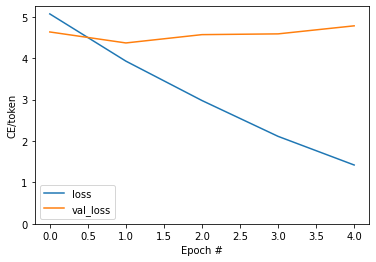

In [208]:
plt.plot(history2.history['loss'], label='loss')
plt.plot(history2.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

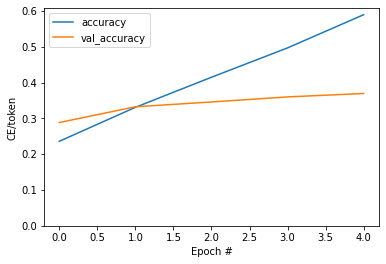

In [209]:
plt.plot(history2.history['masked_acc'], label='accuracy')
plt.plot(history2.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

In [210]:
result2 = model3.translate(['मैं आज घर जाऊंगा।'])
result2[0].numpy().decode()

'i answer to come . '

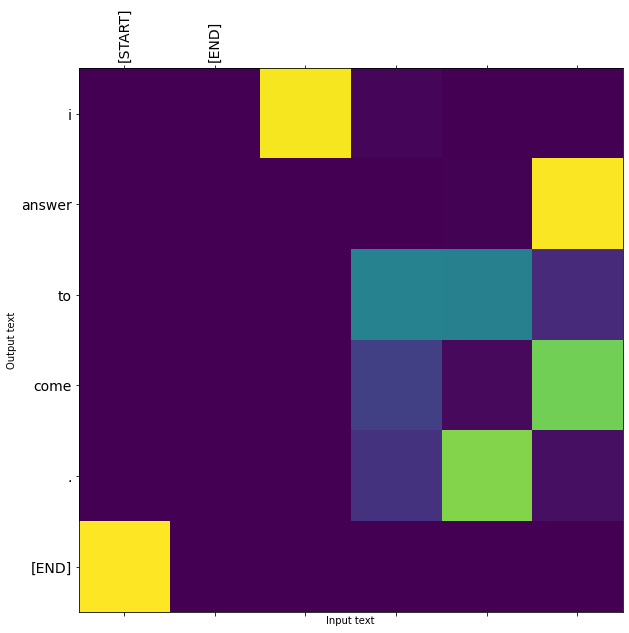

In [211]:
model3.plot_attention('मैं आज घर जाऊंगा।')